In [1]:
import wrangle_zillow
import explore

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
import scipy.stats as stats

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# df = wrangle_zillow.get_zillow()
# df = wrangle_zillow.clean_zillow(df)
# df = explore.add_new_columns(df)
# df.to_csv('ready_to_model')
df = pd.read_csv('ready_to_model')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42136 entries, 0 to 42135
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      42136 non-null  int64  
 1   bathrooms                       42136 non-null  float64
 2   bedrooms                        42136 non-null  int64  
 3   square_footage                  42136 non-null  int64  
 4   county                          42136 non-null  object 
 5   latitude                        42136 non-null  float64
 6   longitude                       42136 non-null  float64
 7   lot_size                        42136 non-null  float64
 8   yearbuilt                       42136 non-null  int64  
 9   structure_tax_value             42136 non-null  float64
 10  tax_value                       42136 non-null  float64
 11  land_tax_value                  42136 non-null  float64
 12  taxamount                       

In [4]:
columns_to_scale = ['bathrooms','bedrooms','square_footage','latitude','longitude','lot_size','yearbuilt',
 'structure_tax_value','tax_value','land_tax_value','taxamount','scaledyear_to_scaledtax',
 'home_price_per_sq_ft','land_price_per_lot_sq_ft', 'summer_scaledyear_to_scaledtax', 'sunday_fall']

In [5]:
train, validate, test, train_scaled, validate_scaled, test_scaled = wrangle_zillow.prepare_all_data(df, columns_to_scale)

# Modeling 

Setting X and y for train, validate and test.

In [6]:
features = ['bathrooms', 'bedrooms', 'square_footage','tax_value', 'season_spring','season_fall',
            'summer_scaledyear_to_scaledtax','sunday_fall','lot_size','yearbuilt']

In [7]:
X_train = train_scaled[features]
y_train = pd.DataFrame(train_scaled.logerror)


X_validate = validate_scaled[features]
y_validate = pd.DataFrame(validate_scaled.logerror)

X_test = test_scaled[features]
y_test = pd.DataFrame(test_scaled.logerror)

Setting baselines based on the mean and median.

In [8]:
# Predicting the mean for taxvaluedollarcnt

logerror_mean = y_train.logerror.mean()
y_train['logerror_pred_mean'] = logerror_mean
y_validate['logerror_pred_mean'] = logerror_mean
y_test['logerror_pred_mean'] = logerror_mean

In [9]:
# Predicting the median for taxvaluedollarcnt

logerror_median = y_train.logerror.median()
y_train['logerror_pred_median'] = logerror_median
y_validate['logerror_pred_median'] = logerror_median
y_test['logerror_pred_median'] = logerror_median

In [10]:
y_train.head()

,logerror,logerror_pred_mean,logerror_pred_median
28383,-0.004393,0.00501,0.004832
2540,-0.053424,0.00501,0.004832
32154,0.029549,0.00501,0.004832
6945,-0.023743,0.00501,0.004832
12155,0.032236,0.00501,0.004832


In [11]:
# Getting the RMSE taxvalue_pred_mean

rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)

# Getting the RMSE taxvalue_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median)**(1/2)

print("\nRMSE using Median\nTrain/In-Sample: ", rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)

RMSE using Mean
Train/In-Sample:  0.055492469733837424 
Validate/Out-of-Sample:  0.05475500966675738

RMSE using Median
Train/In-Sample:  0.05549275681923627 
Validate/Out-of-Sample:  0.05475430782334583


# Linear Regression (OLS)
Creating and validating a Linear Regression model.

In [12]:
# create the model
lm = LinearRegression()

#fit the model
lm.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.055268650124660354 
Validation/Out-of-Sample:  0.054480535479703454


# LassoLars
Creating and validating a LassoLars model.

In [13]:
# create the model
lars = LassoLars(alpha=1.0)

# fit the model
lars.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

print("RMSE for OLS using LassoLars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LassoLars
Training/In-Sample:  0.05549246973383742 
Validation/Out-of-Sample:  0.05475500966675738


# Polynomial Regression
Creating and validatiing a polynomial regressor.

In [14]:
# making the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2, )

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [15]:
# create the model
lm2 = LinearRegression(normalize=True)

#fit the model
lm2.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(1/2)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(1/2)

print("RMSE for OLS using Polynomial Regression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using Polynomial Regression
Training/In-Sample:  0.05513954897390504 
Validation/Out-of-Sample:  0.05449586899964525


In [16]:
# This is just to predict the RMSE on validate for LA county
la_only_validate_RMSE = mean_squared_error(y_validate[validate_scaled.county =='los_angeles'].logerror, y_validate[validate_scaled.county =='los_angeles'].logerror_pred_lm2)**(1/2)
la_only_validate_RMSE

0.057738437267318116

In [17]:
# This is just to predict the RMSE on validate for orange county
orange_only_validate_RMSE = mean_squared_error(y_validate[validate_scaled.county =='orange'].logerror, y_validate[validate_scaled.county =='orange'].logerror_pred_lm2)**(1/2)
orange_only_validate_RMSE

0.04851411279112672

In [18]:
# This is just to predict the RMSE on validate for ventura county
ventura_only_validate_RMSE = mean_squared_error(y_validate[validate_scaled.county =='ventura'].logerror, y_validate[validate_scaled.county =='ventura'].logerror_pred_lm2)**(1/2)
ventura_only_validate_RMSE

0.048740021993889764

In [19]:
mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)

0.05475500966675738

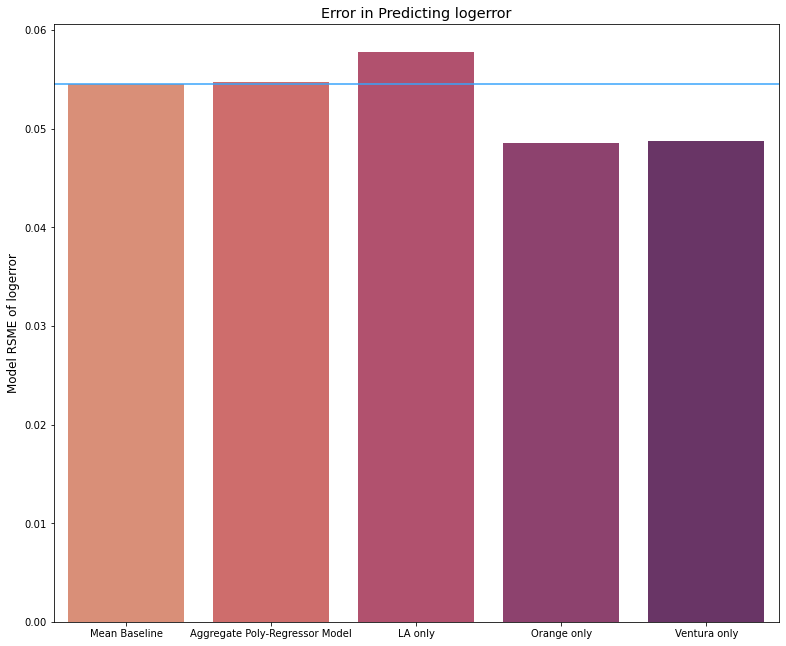

In [20]:
plt.figure(figsize=(13,11))
aggregate_poly_model_validation = rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)
mean_model_validation = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(1/2)
    
sns.barplot(x = ['Mean Baseline', 'Aggregate Poly-Regressor Model', 'LA only', 'Orange only', 'Ventura only'], 
            y = [mean_model_validation, aggregate_poly_model_validation, la_only_validate_RMSE, orange_only_validate_RMSE, ventura_only_validate_RMSE], palette='flare')
plt.axhline(mean_model_validation, color = '#38a4fc')
plt.ylabel('Model RSME of logerror', size = 'large')
plt.title('Error in Predicting logerror',size = 'x-large')
plt.show()

# Other models

First I will bring in other models to see if any offer a better regression.

In [21]:
# importing other models to use
from sklearn.linear_model import Lars, Lasso, LassoLarsCV, LassoLarsIC, Ridge, SGDRegressor, ARDRegression, BayesianRidge, HuberRegressor, PassiveAggressiveRegressor


In [22]:
for model in [Lars(), Lasso(), LassoLarsCV(), LassoLarsIC(), Ridge(), SGDRegressor(), ARDRegression(), BayesianRidge(), HuberRegressor(), PassiveAggressiveRegressor()]:
    # create the model
    test_model = model

    # fit the model
    test_model.fit(X_train, y_train.logerror)

    # predict train
    y_train['logerror_pred_test'] = test_model.predict(X_train)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_test)**(1/2)

    # predict validate
    y_validate['logerror_pred_test'] = test_model.predict(X_validate)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_test)**(1/2)

    print(f"\nRMSE for {model}\nTraining/In-Sample: ", rmse_train, 
          "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Lars()
Training/In-Sample:  0.055268650124660354 
Validation/Out-of-Sample:  0.054480535479703454

RMSE for Lasso()
Training/In-Sample:  0.05549246973383742 
Validation/Out-of-Sample:  0.05475500966675738

RMSE for LassoLarsCV()
Training/In-Sample:  0.055270980617623186 
Validation/Out-of-Sample:  0.054476938936798114

RMSE for LassoLarsIC()
Training/In-Sample:  0.055270234131998656 
Validation/Out-of-Sample:  0.05447680163968107

RMSE for Ridge()
Training/In-Sample:  0.05526865378241285 
Validation/Out-of-Sample:  0.05448039729708562

RMSE for SGDRegressor()
Training/In-Sample:  0.05530397891666081 
Validation/Out-of-Sample:  0.054499352693850145

RMSE for ARDRegression()
Training/In-Sample:  0.05537279161395794 
Validation/Out-of-Sample:  0.054550861845181674

RMSE for BayesianRidge()
Training/In-Sample:  0.05527083692371705 
Validation/Out-of-Sample:  0.05447963455292955

RMSE for HuberRegressor()
Training/In-Sample:  0.05528397625360514 
Validation/Out-of-Sample:  0.05451

Finally I wanna try to use a decision tree regressor

In [23]:
from sklearn.tree import DecisionTreeRegressor

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=3)
regr_3 = DecisionTreeRegressor(max_depth=4)
regr_4 = DecisionTreeRegressor(max_depth=5)
regr_5 = DecisionTreeRegressor(max_depth=8)
regr_6 = DecisionTreeRegressor(max_depth=10)

for model in [regr_1, regr_2,regr_3,regr_4,regr_5,regr_6]:
    # create the model
    test_model = model

    # fit the model
    test_model.fit(X_train, y_train.logerror)

    # predict train
    y_train['logerror_pred_test'] = test_model.predict(X_train)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_test)**(1/2)

    # predict validate
    y_validate['logerror_pred_test'] = test_model.predict(X_validate)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_test)**(1/2)

    print(f"\nRMSE for {model}\nTraining/In-Sample: ", rmse_train, 
          "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for DecisionTreeRegressor(max_depth=2)
Training/In-Sample:  0.05532925943555161 
Validation/Out-of-Sample:  0.054558322379920414

RMSE for DecisionTreeRegressor(max_depth=3)
Training/In-Sample:  0.05525999360229787 
Validation/Out-of-Sample:  0.05455494124892726

RMSE for DecisionTreeRegressor(max_depth=4)
Training/In-Sample:  0.055133789518387655 
Validation/Out-of-Sample:  0.054611936824818415

RMSE for DecisionTreeRegressor(max_depth=5)
Training/In-Sample:  0.054930266443211334 
Validation/Out-of-Sample:  0.05482561421798552

RMSE for DecisionTreeRegressor(max_depth=8)
Training/In-Sample:  0.053953105776203186 
Validation/Out-of-Sample:  0.055629150274095256

RMSE for DecisionTreeRegressor(max_depth=10)
Training/In-Sample:  0.05293871389753404 
Validation/Out-of-Sample:  0.056706420254062646


The best performing DecisionTreeRegressor is max_depth 3

In [24]:
# initial_model_results = pd.read_clipboard()

# initial_model_results

In [25]:
# initial_model_results.to_csv('model_results.csv', index=False)
model_results = pd.read_csv('model_results.csv')

In [26]:
model_results['cumulative_RMSE'] = model_results.train_RMSE + model_results.validate_RMSE
model_results['diff_RMSE'] = model_results.train_RMSE - model_results.validate_RMSE
model_results

,model,train_RMSE,validate_RMSE,cumulative_RMSE,diff_RMSE
0,train_mean,0.055492,0.054755,0.110247,0.000737
1,train_median,0.055493,0.054754,0.110247,0.000738
2,linear_regression_ols,0.055270,0.054481,0.109751,0.000789
3,lasso_lars,0.055492,0.054755,0.110247,0.000737
4,polynomial_regression,0.055138,0.054489,0.109628,0.000649
5,least_angle_lars,0.055270,0.054481,0.109751,0.000789
6,coordinate_descent_lasso,0.055492,0.054755,0.110247,0.000737
7,least_angle_LassoLarsCV,0.055273,0.054478,0.109750,0.000795
8,least_angle_LassoLarsIC,0.055272,0.054478,0.109749,0.000794
9,ridge_regressor,0.055270,0.054481,0.109751,0.000789


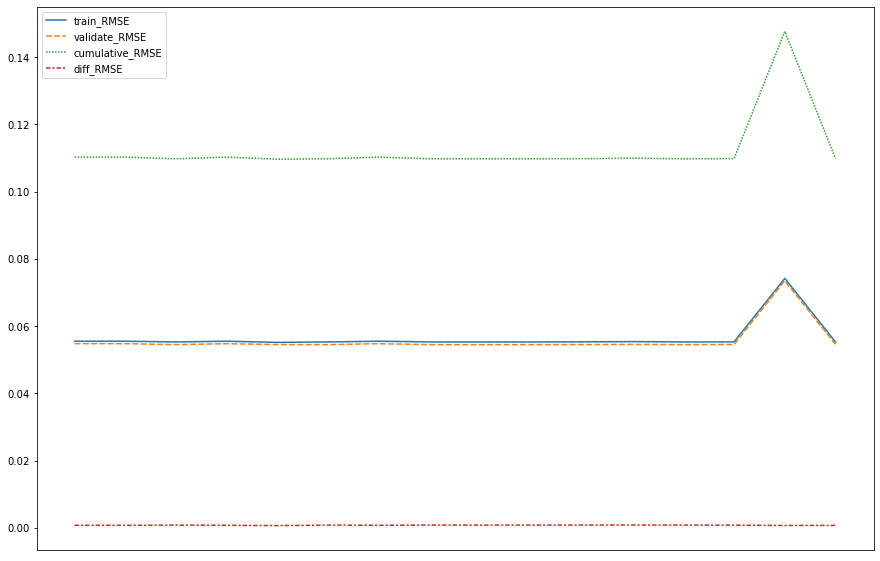

In [27]:
plt.figure(figsize=(15,10))
mod = sns.lineplot(data=model_results)
mod.set(xticklabels=[])
mod.set(xticks=[])
plt.show()

Passive Aggressive is throwing off the plot of the results so I'm going to throw it out in order to better visualize the data.

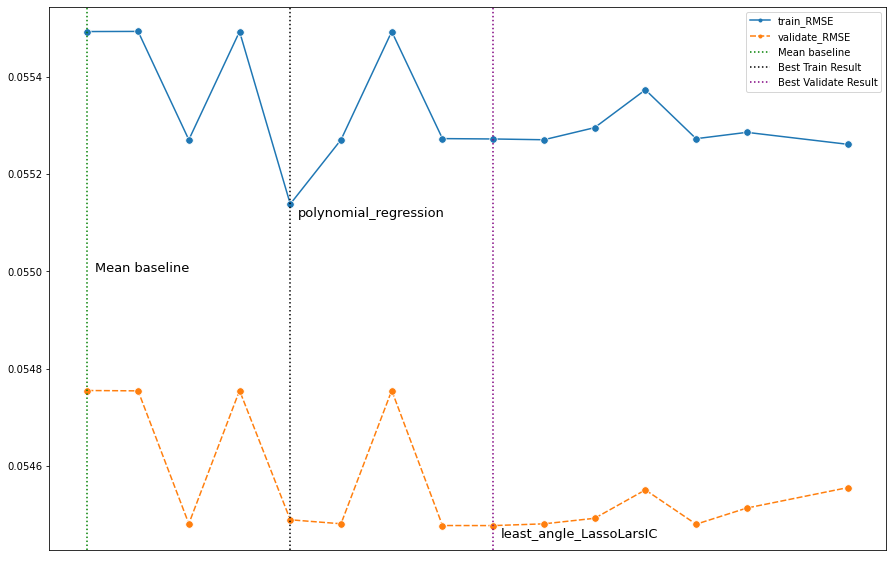

In [28]:
to_model = model_results[model_results.model != 'passive_aggressive_regressor'].drop(['cumulative_RMSE', 'diff_RMSE'], axis=1)

plt.figure(figsize=(15,10))
mod = sns.lineplot(data=to_model, markers=['.','.'],markersize=15)

mod.axvline(model_results.model.iloc[0], label = 'Mean baseline', ls = ':', color = 'green')
xymean = .15,.055
mod.annotate(text = 'Mean baseline', xy = (xymean), size=13)

mod.axvline(model_results.train_RMSE.idxmin(), label = 'Best Train Result', ls = ':', color = 'black')
xytrain = model_results.train_RMSE.idxmin()+.15,model_results.train_RMSE.min()-.000025
mod.annotate(text = model_results.loc[model_results.train_RMSE.idxmin()].model, xy = (xytrain), size=13)

mod.axvline(model_results.validate_RMSE.idxmin(), label = 'Best Validate Result', ls = ':', color = 'purple')
xyvalidate = model_results.validate_RMSE.idxmin()+.15,model_results.validate_RMSE.min()-.000025
mod.annotate(text = model_results.loc[model_results.validate_RMSE.idxmin()].model, xy = (xyvalidate), size=13)

plt.legend()
mod.set(xticklabels=[])
mod.set(xticks=[])
plt.show()

In [29]:
model_results.sort_values('validate_RMSE')

,model,train_RMSE,validate_RMSE,cumulative_RMSE,diff_RMSE
8,least_angle_LassoLarsIC,0.055272,0.054478,0.109749,0.000794
7,least_angle_LassoLarsCV,0.055273,0.054478,0.109750,0.000795
12,bayesian_ridge,0.055272,0.054480,0.109753,0.000792
9,ridge_regressor,0.055270,0.054481,0.109751,0.000789
2,linear_regression_ols,0.055270,0.054481,0.109751,0.000789
5,least_angle_lars,0.055270,0.054481,0.109751,0.000789
4,polynomial_regression,0.055138,0.054489,0.109628,0.000649
10,sgd_regressor,0.055295,0.054493,0.109788,0.000803
13,huber_regressor,0.055285,0.054514,0.109799,0.000772
11,ard_regressor,0.055373,0.054551,0.109924,0.000822


In [30]:
model_results.sort_values('train_RMSE')

,model,train_RMSE,validate_RMSE,cumulative_RMSE,diff_RMSE
4,polynomial_regression,0.055138,0.054489,0.109628,0.000649
15,decision_tree_regressor,0.055261,0.054556,0.109816,0.000705
2,linear_regression_ols,0.055270,0.054481,0.109751,0.000789
5,least_angle_lars,0.055270,0.054481,0.109751,0.000789
9,ridge_regressor,0.055270,0.054481,0.109751,0.000789
8,least_angle_LassoLarsIC,0.055272,0.054478,0.109749,0.000794
12,bayesian_ridge,0.055272,0.054480,0.109753,0.000792
7,least_angle_LassoLarsCV,0.055273,0.054478,0.109750,0.000795
13,huber_regressor,0.055285,0.054514,0.109799,0.000772
10,sgd_regressor,0.055295,0.054493,0.109788,0.000803


In [31]:
model_results.sort_values('cumulative_RMSE')

,model,train_RMSE,validate_RMSE,cumulative_RMSE,diff_RMSE
4,polynomial_regression,0.055138,0.054489,0.109628,0.000649
8,least_angle_LassoLarsIC,0.055272,0.054478,0.109749,0.000794
7,least_angle_LassoLarsCV,0.055273,0.054478,0.109750,0.000795
9,ridge_regressor,0.055270,0.054481,0.109751,0.000789
2,linear_regression_ols,0.055270,0.054481,0.109751,0.000789
5,least_angle_lars,0.055270,0.054481,0.109751,0.000789
12,bayesian_ridge,0.055272,0.054480,0.109753,0.000792
10,sgd_regressor,0.055295,0.054493,0.109788,0.000803
13,huber_regressor,0.055285,0.054514,0.109799,0.000772
15,decision_tree_regressor,0.055261,0.054556,0.109816,0.000705


In [32]:
model_results.sort_values('diff_RMSE')

,model,train_RMSE,validate_RMSE,cumulative_RMSE,diff_RMSE
4,polynomial_regression,0.055138,0.054489,0.109628,0.000649
14,passive_aggressive_regressor,0.074161,0.073474,0.147635,0.000687
15,decision_tree_regressor,0.055261,0.054556,0.109816,0.000705
0,train_mean,0.055492,0.054755,0.110247,0.000737
3,lasso_lars,0.055492,0.054755,0.110247,0.000737
6,coordinate_descent_lasso,0.055492,0.054755,0.110247,0.000737
1,train_median,0.055493,0.054754,0.110247,0.000738
13,huber_regressor,0.055285,0.054514,0.109799,0.000772
2,linear_regression_ols,0.055270,0.054481,0.109751,0.000789
5,least_angle_lars,0.055270,0.054481,0.109751,0.000789


Basically in every metric polynomial regression comes out as the best performing model.

So the best performing holistic model for predicting logerror seems to be polynomial regression with a validate RMSE of .054489 which beats the mean validate RMSE of 0.054755. This is an improvement of 0.000266 logerror. This validate RMSE of .054489 is my new baseline to beat when trying with models broken out by county.

# Individual county models

In [33]:
import model

In [34]:
train_la, train_orange, train_ventura = model.county_train_split(train_scaled)
validate_la, validate_orange, validate_ventura = model.county_validate_split(validate_scaled)
test_la, test_orange, test_ventura = model.county_test_split(test_scaled)

In [35]:
X_train_la, y_train_la, X_train_orange, y_train_orange, X_train_ventura, y_train_ventura = model.county_train_x_y(train_la, train_orange, train_ventura, features)

X_validate_la, y_validate_la, X_validate_orange, y_validate_orange, X_validate_ventura, y_validate_ventura = model.county_validate_x_y(validate_la, validate_orange, validate_ventura, features)

X_test_la, y_test_la, X_test_orange, y_test_orange, X_test_ventura, y_test_ventura = model.county_test_x_y(test_la, test_orange, test_ventura, features)

In [36]:
y_train_la, y_validate_la, y_test_la = model.la_county_model(X_train_la, y_train_la, X_validate_la, y_validate_la, X_test_la, y_test_la)

y_train_orange, y_validate_orange, y_test_orange = model.orange_county_model(X_train_orange, y_train_orange, X_validate_orange, y_validate_orange, X_test_orange, y_test_orange)

y_train_ventura, y_validate_ventura, y_test_ventura = model.ventura_county_model(X_train_ventura, y_train_ventura, X_validate_ventura, y_validate_ventura, X_test_ventura, y_test_ventura)

RMSE for Polynomial Model for LA county

Training/In-Sample:  0.05835875934375348 
Validation/Out-of-Sample:  0.05782466985359601
RMSE for Polynomial Model for Orange county

Training/In-Sample:  0.04921552900613214 
Validation/Out-of-Sample:  0.048735600842056
RMSE for Polynomial Model for Orange county

Training/In-Sample:  0.04825271250177138 
Validation/Out-of-Sample:  0.05001311302440826


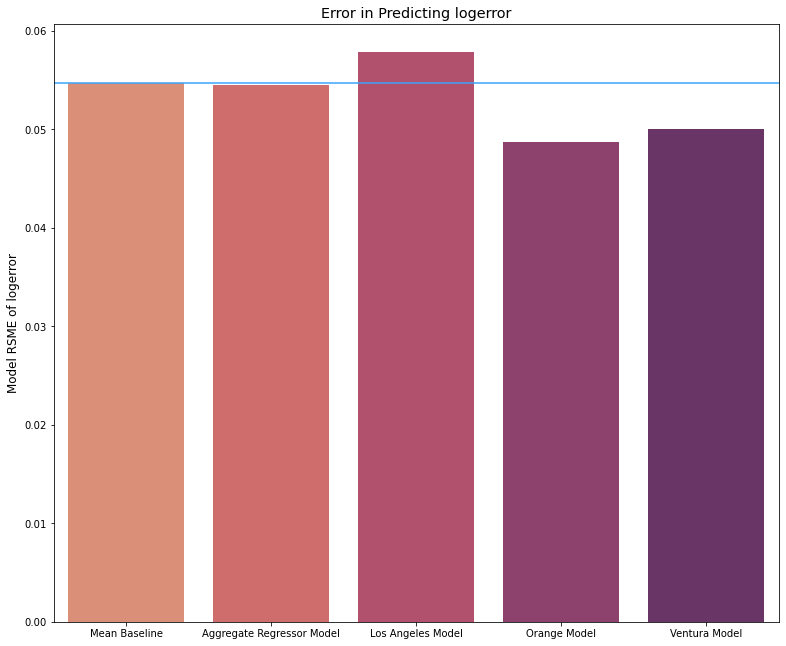

In [37]:
model.validate_results_plot(model_results, y_validate_la, y_validate_orange, y_validate_ventura)


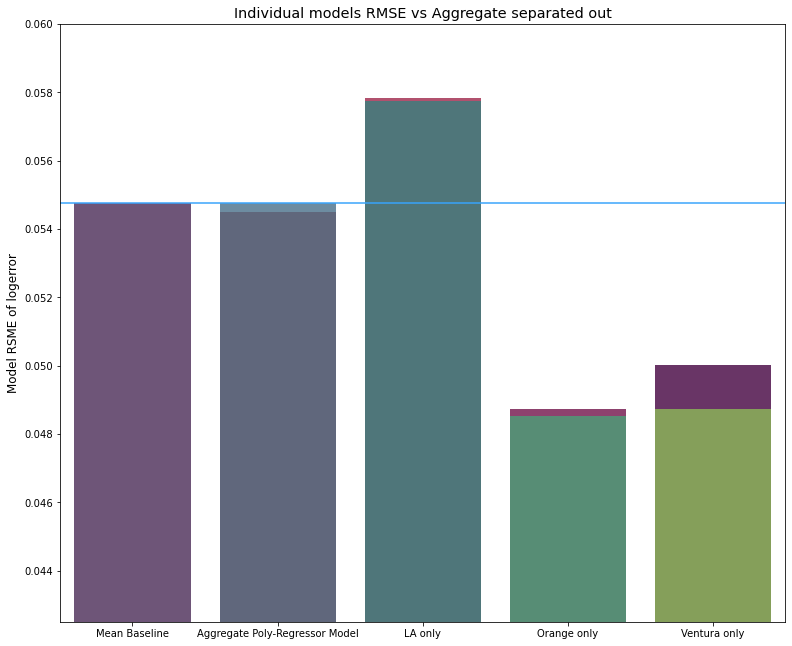

In [38]:
aggregate_model_validation = model_results[model_results.model == 'polynomial_regression'].validate_RMSE.values[0]
mean_model_validation = model_results[model_results.model == 'train_mean'].validate_RMSE.values[0]
la_model_validation = mean_squared_error(y_validate_la.logerror, y_validate_la.logerror_pred_lm2)**(1/2)
orange_model_validation = mean_squared_error(y_validate_orange.logerror, y_validate_orange.logerror_pred_lm2)**(1/2)
ventura_model_validation = mean_squared_error(y_validate_ventura.logerror, y_validate_ventura.logerror_pred_lm2)**(1/2)

plt.figure(figsize=(13,11))
g = sns.barplot(x = ['Mean Baseline', 'Aggregate Regressor Model', 'Los Angeles Model', 'Orange Model', 'Ventura Model'], 
            y = [mean_model_validation, aggregate_model_validation, la_model_validation, orange_model_validation, ventura_model_validation], palette='flare')

g = sns.barplot(x = ['Mean Baseline', 'Aggregate Poly-Regressor Model', 'LA only', 'Orange only', 'Ventura only'], 
            y = [mean_model_validation, aggregate_poly_model_validation, la_only_validate_RMSE, orange_only_validate_RMSE, ventura_only_validate_RMSE], palette='viridis', alpha =.75)
g.set(ylim=(.0425,.06))

plt.title('Individual models RMSE vs Aggregate separated out',size = 'x-large')
plt.axhline(mean_model_validation, color = '#38a4fc')
plt.ylabel('Model RSME of logerror', size = 'large')

plt.show()

When comparing the aggregated model separated out by county we find that it actually does better at predicting the logerror than when using individual models. To me this seems to indicate that the overall model actually does a better job at predicting logerror. I will use the aggregate model to test and display results.

In [40]:
# making the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2, )

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

# create the model
lm2 = LinearRegression(normalize=True)

#fit the model
lm2.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(1/2)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(1/2)

print("RMSE for Polynomial Regression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
# predict test
y_test['logerror_pred_lm2'] = lm2.predict(X_test_degree2)
y_test = y_test.drop(y_test.logerror_pred_lm2.idxmax())
# evaluate: rmse
rmse_test_aggregate = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm2)**(1/2)
print("\nRMSE for Aggregate Polynomial Model \nTest/Out-of-Sample: ", rmse_test_aggregate)

RMSE for Polynomial Regression
Training/In-Sample:  0.05513954897390504 
Validation/Out-of-Sample:  0.05449586899964525

RMSE for Aggregate Polynomial Model 
Test/Out-of-Sample:  0.05460101363406295


The overall test results are fine. 

In [46]:
# This is just to predict the RMSE on validate for LA county
la_only_test_RMSE = mean_squared_error(y_test[test_scaled.county =='los_angeles'].logerror, y_test[test_scaled.county =='los_angeles'].logerror_pred_lm2)**(1/2)
la_only_test_RMSE

0.05710762275848051

In [49]:
# This is just to predict the RMSE on validate for orange county
orange_only_test_RMSE = mean_squared_error(y_test[test_scaled.county =='orange'].logerror, y_test[test_scaled.county =='orange'].logerror_pred_lm2)**(1/2)
orange_only_test_RMSE

0.05016914880634738

In [48]:
# This is just to predict the RMSE on validate for ventura county
ventura_only_test_RMSE = mean_squared_error(y_test[test_scaled.county =='ventura'].logerror, y_test[test_scaled.county =='ventura'].logerror_pred_lm2)**(1/2)
ventura_only_test_RMSE

0.048740021993889764

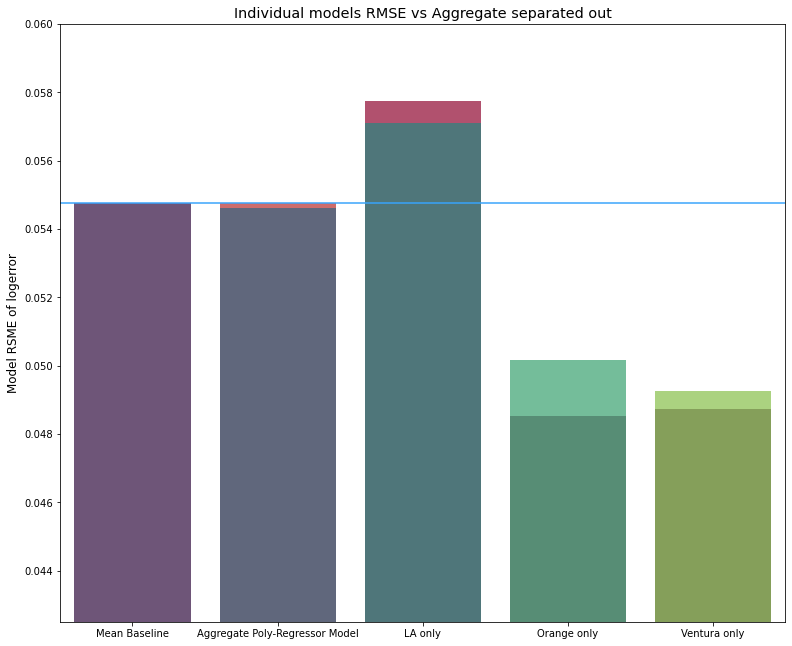

In [50]:
rmse_test_aggregate = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm2)**(1/2)
mean_model_validation = model_results[model_results.model == 'train_mean'].validate_RMSE.values[0]

plt.figure(figsize=(13,11))
g = sns.barplot(x = ['Mean Baseline', 'Aggregate Regressor Model', 'Los Angeles Model', 'Orange Model', 'Ventura Model'], 
            y = [mean_model_validation, aggregate_poly_model_validation, la_only_validate_RMSE, orange_only_validate_RMSE, ventura_only_validate_RMSE], palette='flare')

g = sns.barplot(x = ['Mean Baseline', 'Aggregate Poly-Regressor Model', 'LA only', 'Orange only', 'Ventura only'], 
            y = [mean_model_validation, rmse_test_aggregate, la_only_test_RMSE, orange_only_test_RMSE, ventura_only_test_RMSE], palette='viridis', alpha =.75)
g.set(ylim=(.0425,.06))

plt.title('Individual models RMSE vs Aggregate separated out',size = 'x-large')
plt.axhline(mean_model_validation, color = '#38a4fc')
plt.ylabel('Model RSME of logerror', size = 'large')

plt.show()